In [2]:
from math import *
from random import uniform as rng
import numpy as np
import matplotlib.pyplot as plt

## Global data

In [4]:
LV_MAX = 196
HIT_DAMAGE_LIMIT = 999999

### Character properties

In [5]:
# Properties of Luna

LUNA = {
    'attack': 14799 + (240 + 15 * LV_MAX),
    'critical': 1162,
    'defence_phys': 214,
    'defence_magic': 316,
    'hp': 23708,
    'tp_rise': 13,
    'tp_rest': 28
}

LUNA_4 = {
    'attack': 14237 + (240 + 15 * LV_MAX),
    'critical': 1162,
    'defence_phys': 190,
    'defence_magic': 292,
    'hp': 20217,
    'tp_rise': 13,
    'tp_rest': 28
}

LUNA_3 = {
    'attack': 13673 + (240 + 15 * LV_MAX),
    'critical': 1162,
    'defence_phys': 163,
    'defence_magic': 265,
    'hp': 16723,
    'tp_rise': 13,
    'tp_rest': 28
}


# Properties of Nyaru

NYARU = {
    'attack': 15367 + (240 + 15 * LV_MAX),
    'critical': 1367,
    'defence_phys': 227,
    'defence_magic': 288,
    'hp': 23479,
    'tp_rise': 13,
    'tp_rest': 17
}

NYARU_4 = {
    'attack': 14792 + (240 + 15 * LV_MAX),
    'critical': 1367,
    'defence_phys': 201,
    'defence_magic': 268,
    'hp': 20041,
    'tp_rise': 13,
    'tp_rest': 17
}

NYARU_3 = {
    'attack': 14217 + (240 + 15 * LV_MAX),
    'critical': 1367,
    'defence_phys': 172,
    'defence_magic': 246,
    'hp': 16599,
    'tp_rise': 13,
    'tp_rest': 17
}

### Skills and battle fomules

In [6]:
def tp_integer(tp_orignal, tp_rise):
    return round(tp_orignal * (1 + tp_rise/100.))

def yukari_tp(tp_rise, lv = LV_MAX):
    return round((75 + 2.5 *lv) * (1+tp_rise/100.))

def miren_tp(tp_rise, lv = LV_MAX):
    return round((250 + 1.35 * lv))

def action_tp(tp_rise, lv = LV_MAX):
    return round(90*(1+tp_rise/100.))

def hurt_tp_magic(damage, role):
    return hurt_tp(damage, role['hp'], role['defence_magic'],role['tp_rise'])

def hurt_tp(damage, hp, defence, tp_rise):
    return round(damage/(1+defence/100.) / hp * 500 * (1+tp_rise/100.))

def LogBarrier(damage, threshold=850000, factor=100000):
    if(damage < threshold):
        return damage
    else:
        return (factor * log((damage-threshold)/factor + 1) + threshold)
  
def critical_rate(criVal, enemyLv, lv = LV_MAX):
    return (0.05 * criVal / 100 * lv / enemyLv)

def critical_damage(orignalDamage, rate, criticalDamageBuff = 0., criticalCoeff = 2.0):
    hit = 0
    if(rng(0,1) < rate ):
        hit = round(orignalDamage * criticalCoeff * (1 + criticalDamageBuff))
    else:
        hit = round(orignalDamage)
    return min(HIT_DAMAGE_LIMIT, hit)

NYARU_UB_BUFF_COEFF = 0.1125
def nyaruUB(atackWithBuff, criticalWithBuff, criticalDamageBuff = 0., enemyLv = LV_MAX, lv = LV_MAX, detail=False):
    # split in 10 parts = 1/13 * 9 + 4/13
    totalDamage = 0
    orignalDamage = 60 * (LV_MAX + 1 ) + 4.8 * atackWithBuff
    for i in ([1] * 9 + [4]):
        totalDamage += critical_damage(orignalDamage*i/13, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff)
    if detail:
        return [round(orignalDamage * 1/13), round(orignalDamage * 4/13), totalDamage]
    else:
        return totalDamage

In [7]:
print(action_tp(13)*2 + yukari_tp(13))
print(hurt_tp_magic(LUNA['attack'], NYARU_3))

842
177


#### Test : Nyaru UB damage distribution
Nyaru's UB is splitted into 10 hits, including the first 9 hits took 1/13 damage and the last hit took 4/13. For simplicity, I suppose the critical for each hit is calculated independently. 

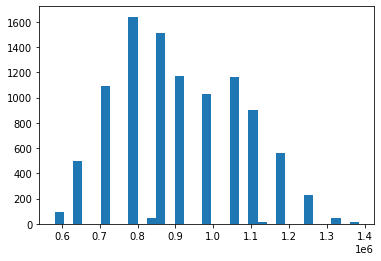

In [14]:
ex4nyaru = lambda x : nyaruUB(NYARU['attack'] + x, NYARU['critical']+180,0.25,400)
a = [ex4nyaru(100000) for i in range(0,10000)]
_ = plt.hist(a, bins='auto')

In [9]:
nyaruUB(NYARU['attack'] + (28+10.5+10.5+20+6+18) * (LV_MAX +1) + 1308, NYARU['critical'],0.15,400, LV_MAX, True)

[15005, 60020, 331609]

### TP interger check

In [10]:
tp_cache = 1.10
tp_charge = 107.9
tp_charge_int = 108

for i in range(0,20):
    tp_up_tmp = tp_cache + 0.01 * i
    print('%.2f %.2f %.2f' % (tp_up_tmp, tp_charge * tp_up_tmp, tp_charge_int * tp_up_tmp))

1.10 118.69 118.80
1.11 119.77 119.88
1.12 120.85 120.96
1.13 121.93 122.04
1.14 123.01 123.12
1.15 124.09 124.20
1.16 125.16 125.28
1.17 126.24 126.36
1.18 127.32 127.44
1.19 128.40 128.52
1.20 129.48 129.60
1.21 130.56 130.68
1.22 131.64 131.76
1.23 132.72 132.84
1.24 133.80 133.92
1.25 134.88 135.00
1.26 135.95 136.08
1.27 137.03 137.16
1.28 138.11 138.24
1.29 139.19 139.32


## Damage limit with log barrier
After the Nyaru shock in the clan battle of 2020/01, Cygames decided to add a new limitation sign for all the bossed under clan battle mode. According to unpaced data from server, the mechanism is deployed with a simple logarithm for damage above threshold, so called **'log barrier**'.

The logarithm can be manipulated with two parameters, threshold and attenuation coefficient. Latest value in 2021/04 is **850,000** and 100,000.

### Example: Kaya vs Wyvern (2nd phase) 2021/01
[video](https://www.youtube.com/watch?v=DA6hy8W1RTQ) from たつきちゃん

In [ ]:
eff_lv = 187
kaya_attack = 17337
damage_final = 856088
buff_miren = (18+2.5) * (eff_lv +1)
buff_self = (20 *2 + 72) * (1 + eff_lv)

damage = (120 * (eff_lv +1 ) + 9.6 * (kaya_attack + buff_miren + buff_self)) *2
print(int(damage), int(LogBarrier(damage)), int (damage_final))

856262 856074 856088


### UB with multi-hits
The method for multi-hit UB is still unclear. Here I suppose the possible process: 
1.   compute original damage without critical
2.   divide the orignal damage into hits
3.   define critical flags for hits
4.   sum the total damge and apply log barrier
5.   get a ratio of the total damage before and after
6.   apply the ratio to each hit

### Example: working with digit barrier
Another case is from the limitation of hit damage (digit barrier). If Nyaru get more than 320,000 buff, the last hit of UB would exceed it when critical. For Nuneka patterns, the required buff could be even lower, around 275,000. The buff corresponds to 2,850k and 2,450k damage of Nyaru UB in last 18s.

In [47]:
buffRaw = 320000
damageRaw = nyaruUB(NYARU['attack']+320000 , NYARU['critical'], enemyLv=120, detail=True)
print('Nyaru UB with ' + repr(buffRaw) + ' buff: ' +repr(damageRaw))
print('> Last hit with critical: %d' % (damageRaw[1] * 2.0))
print('> Buff required damage of Nyaru UB: ' + repr(int(buffRaw / NYARU_UB_BUFF_COEFF)))

buffNuneka = 275000
damageNuneka = nyaruUB(NYARU['attack']+buffNuneka , NYARU['critical'], criticalDamageBuff=0.15, enemyLv=120, detail=True)
print('Nyaru UB with ' + repr(buffNuneka) + ' buff and Nuneka critical damage buff: ' + repr(damageNuneka))
print('> Last hit with critical: %d' % (damageNuneka[1] * 2.0 * 1.15))
print('> Buff required damage of Nyaru UB: ' + repr(int(buffNuneka / NYARU_UB_BUFF_COEFF)))

Nyaru UB with 320000 buff: [125911, 503645, 3266397]
> Last hit with critical: 1007290
> Buff required damage of Nyaru UB: 2844444
Nyaru UB with 275000 buff and Nuneka critical damage buff: [109296, 437183, 3262419]
> Last hit with critical: 1005520
> Buff required damage of Nyaru UB: 2444444


To verify the method for multi-hit UB, the data from [video](https://www.youtube.com/watch?v=VIWQDPDHeJY) by ハンマリォch. was extracted, which is Nyaru vs Minotaur (3rd phase).

The UB damage of Nyara:

*   1:22, 241310
*   1:18, 535032
*   1:14, 985206
*   1:11, 1120470
*   1:07, 1079101 (no debuff, 100 magical defence)
*   0:59, 1191251



In [79]:
# Rest time (seconds) and total UB damage
exampleNyaruUBDmage = [(82, 241310), (78, 535032), (74, 985206), (71, 1120470), (67, 1079101), (59, 1191251)]

# First UB
otherBuff = (18. + 6. ) * (LV_MAX + 1)
nextUBDamage = nyaruUB(NYARU_4['attack'] - 25 + otherBuff, NYARU['critical'], enemyLv=120, detail=True)
print(nextUBDamage)

# Test A: UB at 1:07
## Neneka's debuff is missing, and the defence is 100, so damage is halved.
ubDamageA = sum(x[1] for x in exampleNyaruUBDmage[0:4])
# buff from Saren (S1, 1:24; S2, 1:15), Nyaru(S2, 1:22/1:12) and Luna (S1, 1:18/1:11/1:07)
otherBuff = (18. + 2.5 + 6. *2 + 7.5 *3) * (LV_MAX + 1)
nextUBDamage = nyaruUB(NYARU_4['attack'] + ubDamageA * NYARU_UB_BUFF_COEFF  + otherBuff, 
                       NYARU_4['critical'], enemyLv=120, detail=True)
print('Total damage: ' + repr(nextUBDamage) + ', damge after logarithm :  ' + repr(round(LogBarrier(nextUBDamage[2] / 2.))))
nextUBDamageWithoutDigitBarrier = nextUBDamage[0] * 2 * 9 + nextUBDamage[1] * 2
print( 'Damage w/o digit barrier: %d, after logarithm : %d' % (nextUBDamageWithoutDigitBarrier , round( LogBarrier(nextUBDamageWithoutDigitBarrier /2. ))))

# Test B: UB at 0:59
# buff from Saren (S2, 1:02; UB, 1:05), Neneka(UB, 1:06) and Luna (S1, 1:11/1:07)
otherBuff = (2.5 + 10.5 + 28 + 7.5 *2 ) * (LV_MAX + 1)
ubDamageB = sum(x[1] for x in exampleNyaruUBDmage[2:5])
nextUBDamage = nyaruUB(NYARU_4['attack'] + ubDamageB * NYARU_UB_BUFF_COEFF  + otherBuff, 
                       NYARU_4['critical'], enemyLv=120, detail=True)
print('Total damage: ' + repr(nextUBDamage) + ', damge after logarithm :  ' + repr(round(LogBarrier(nextUBDamage[2]))))
nextUBDamageWithoutDigitBarrier = nextUBDamage[0] * 2 * 9 + nextUBDamage[1] * 2
print( 'Damage w/o digit barrier: %d, after logarithm : %d' % (nextUBDamageWithoutDigitBarrier , round( LogBarrier(nextUBDamageWithoutDigitBarrier ))))

[9282, 37126, 241319]
Total damage: [131260, 525041, 3362688], damge after logarithm :  1073146
Damage w/o digit barrier: 3412762, after logarithm : 1075799
Total damage: [143909, 575637, 3590361], damge after logarithm :  1184652
Damage w/o digit barrier: 3741636, after logarithm : 1189841


## EX4 Dungeon - Nyaru patterns

Basic Strategy
1. Kill BLACK boss at 1:14 (before first buff clear action)
2. Hit WHITE boss under 50% during 1:02-1:00 (actions to clear buff)

The next action to clear buff is 0:46-0:43, and all the buff would be cleared at the end of damage hits, around 0:43-0:42. So the power of Nyaru-Luna patterns is unlimited in the first 46 seconds.

HP of both boss should be adjusted to achive the above timeline. Upper limit is constrained by the maximum damage of Nyaru with 100% criticals, while lower limit is set to avoid reaching the HP target before the check point (for BLACK boss is more loose than WHITE). Considering the wide gap of level between boss and player (lv. 400  and lv. 196), the critical rate of Nyaru is around 30% to 40%. Therefore, the damage distribution is necessary to select proper range for HP adjusting.


### 1. W-Neneka pattern
Neneka (New year), Saren (Summer), Neneka, Nyaru, Luna


[15005, 60020, 234077]


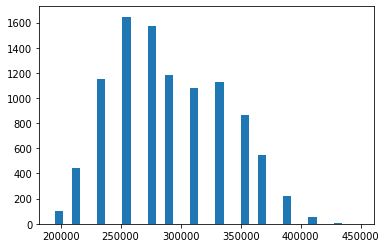

In [13]:
ex4start = lambda x : nyaruUB(NYARU['attack'] + (28+10.5+10.5+20+6+18) * (LV_MAX +1) + 1308, NYARU['critical']+180,0.15,400, detail=x)
print(ex4start(True))
a = [ex4start(False) for i in range(0,10000)]
_ = plt.hist(a, bins='auto')